In [1]:
import sys
import os
import random
import math
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [18]:
# Get the absolute path of the project root directory
project_root = os.path.abspath(os.path.join(os.getcwd()))

# # Ensure the project root directory is in sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Ensure the model directory is also added to sys.path
model_path = os.path.join(project_root, "model")
if model_path not in sys.path:
    sys.path.append(model_path)

# Ensure the src directory is also added to sys.path
src_path = os.path.join(project_root, "src")
if model_path not in sys.path:
    sys.path.append(src_path)

# Import the BlackjackGame and BlackjackGameGym classes
from environment.environment import BlackjackGame
from environment.environment_gym import BlackjackGameGym

# Import the TemporalDifference class
from td_agent import TemporalDifference

# Import utility functions
from utilities import test_td_model, save_td_model, load_q_table, test_ppo_model

# Method 1: Temporal Difference Model

## Train TD Model Using the Optimal Hyperparameters

In [184]:
# Create environment
env = BlackjackGame()

# Create agent
agent = TemporalDifference(
    env=env,
    alpha=0.02,    # Learning rate
    gamma=0.99,    # Discount factor
    epsilon=0.05,  # Exploration rate
    lambd=1     # Trace decay
)

# Define the number of episodes to train
num_episodes = 10000000

# Train Q-learning agent
agent.train(num_episodes=num_episodes, on_policy=False)

100%|██████████| 10000000/10000000 [03:00<00:00, 55545.82it/s]


In [190]:
save_td_model(agent.Q, "best_trained_models/best_q_learning.npy")

TD model is saved to models/q_learning.npy.


## Ture Count = 2

### Policy Visualization

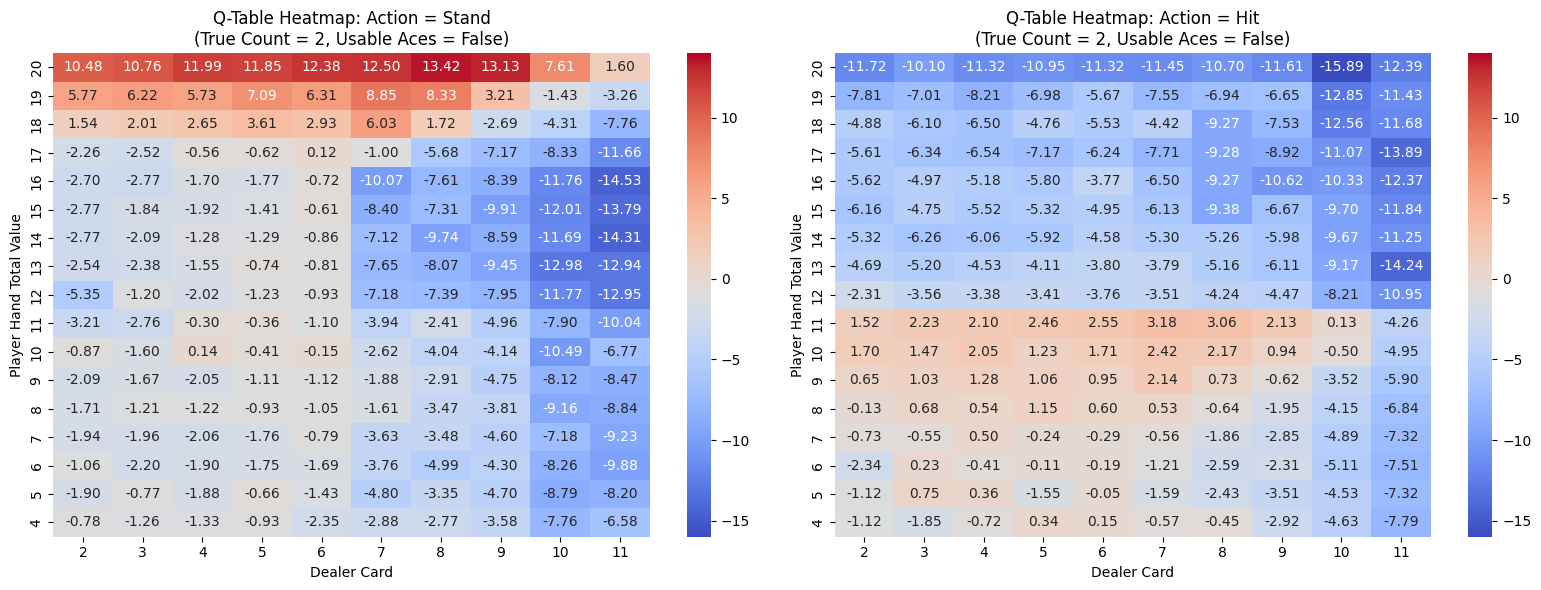

In [185]:
agent.plot_q_table(true_count=2, usable_aces=False)

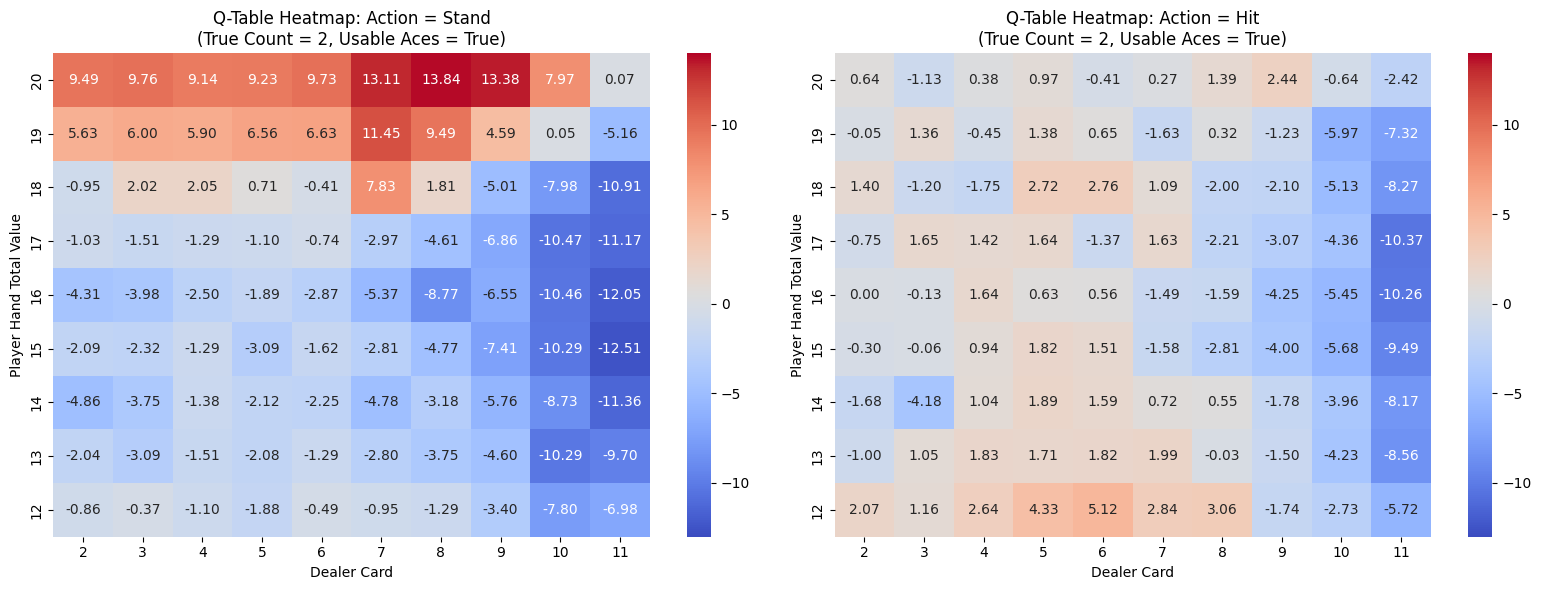

In [186]:
agent.plot_q_table(true_count=2, usable_aces=True)

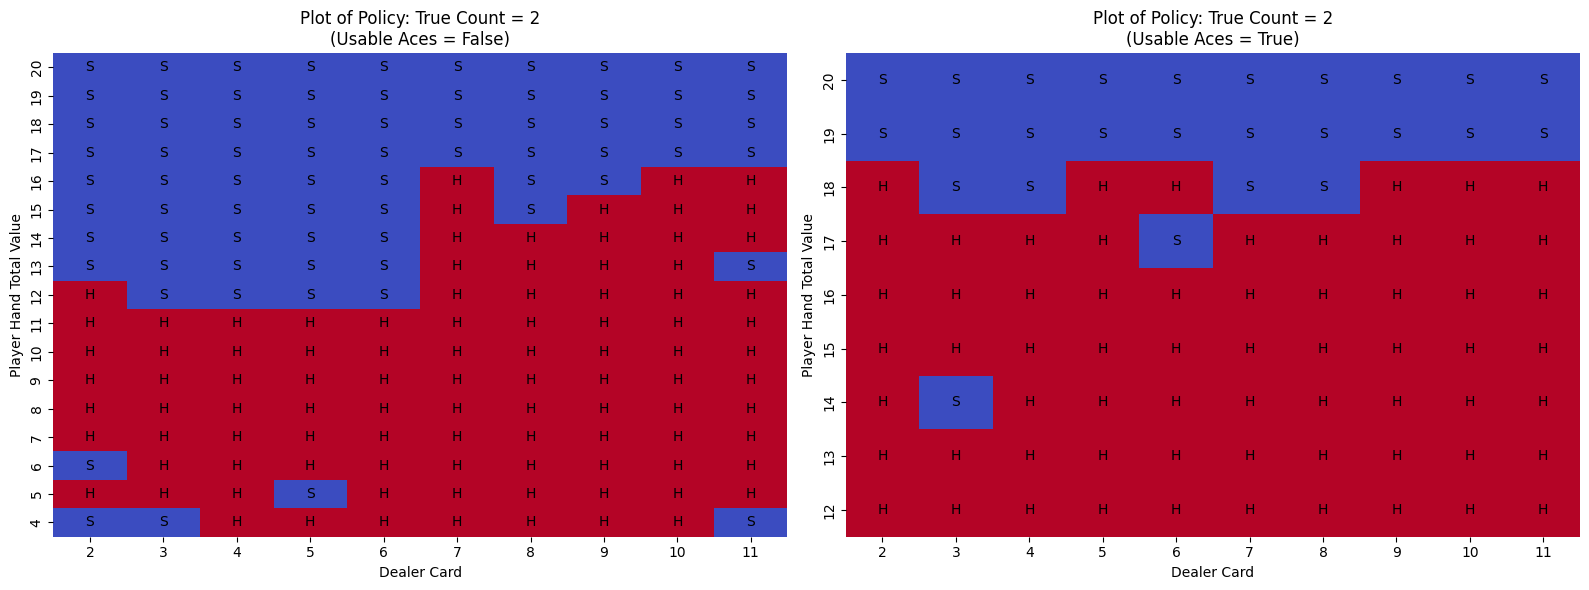

In [187]:
agent.plot_policy(true_count=2)

### Test TD Model When TC = 2

In [189]:
env = BlackjackGame()
test_td_model(agent, env, num_test_games=10000, true_count=2)

Testing Games: 100%|██████████| 10000/10000 [00:00<00:00, 14190.12it/s]

Results after 10000 test games:
Win Rate: 45.06%
Loss Rate: 47.28%
Tie Rate: 7.66%
Blackjack Rate: 6.18%
Total Reward: 1740.0
Average Reward: 0.17


## True Count = -2

In [8]:
# Create environment
env = BlackjackGame()

# Create agent
agent = TemporalDifference(
    env=env,
    alpha=0.02,    # Learning rate
    gamma=0.99,    # Discount factor
    epsilon=0.05,  # Exploration rate
    lambd=1     # Trace decay
)

agent.Q = load_q_table("models/q_learning.npy")

TD model is loaded from models/q_learning.npy.


### Policy Visualization

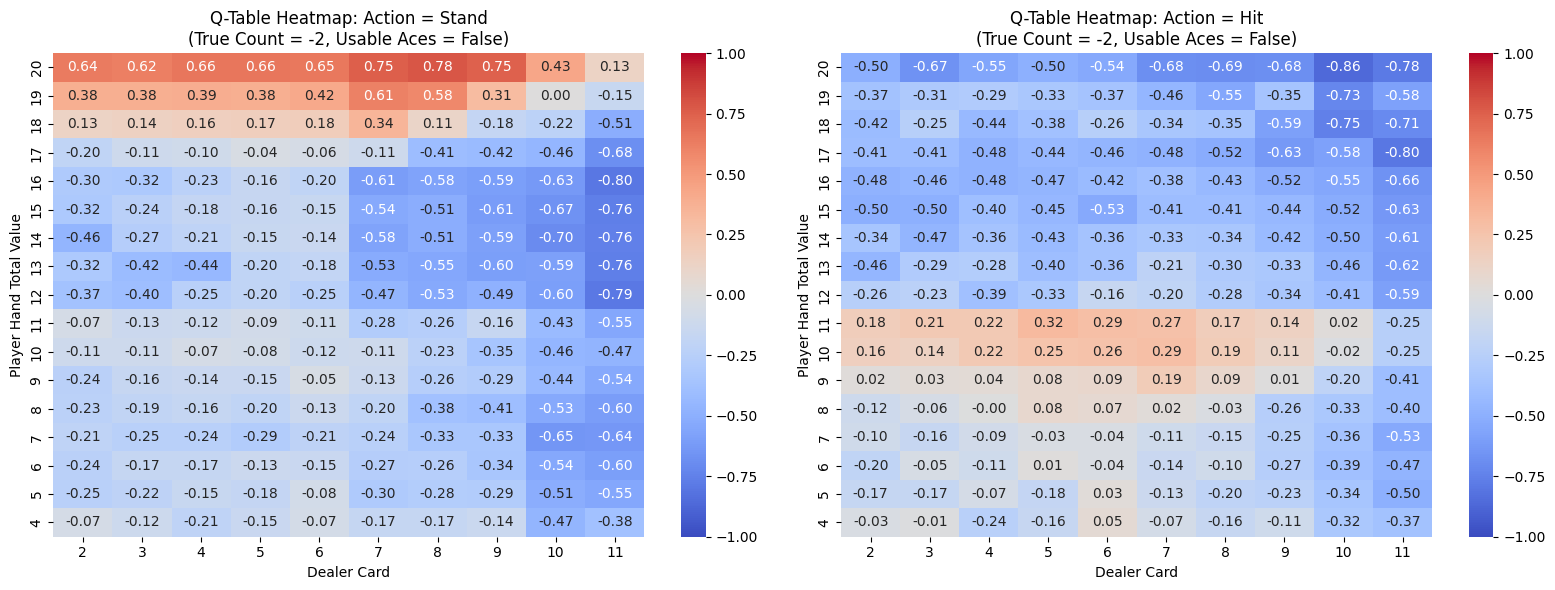

In [9]:
agent.plot_q_table(true_count=-2, usable_aces=False)

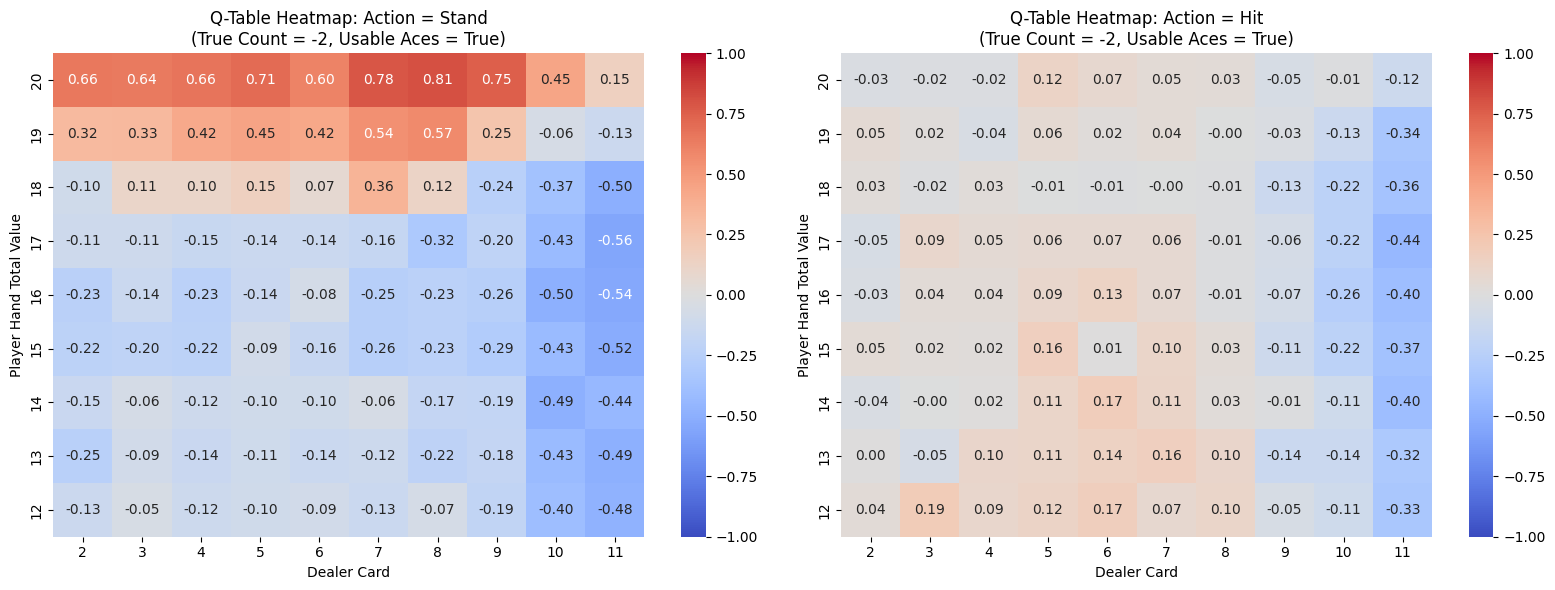

In [10]:
agent.plot_q_table(true_count=-2, usable_aces=True)

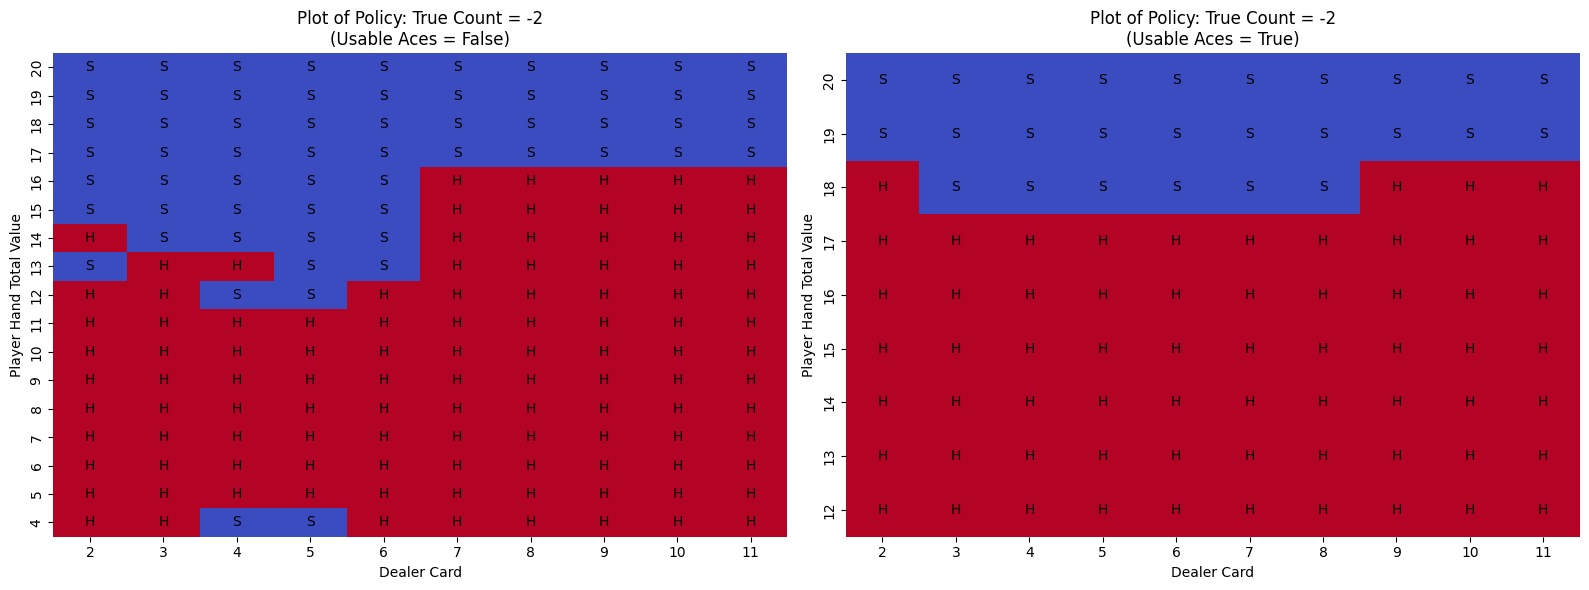

In [11]:
agent.plot_policy(true_count=-2)

### Test TD Model When TC = -2

In [12]:
env = BlackjackGame()
test_td_model(agent, env, num_test_games=10000, true_count=-2)

Testing Games: 100%|██████████| 10000/10000 [00:00<00:00, 14170.62it/s]


{'win_rate': 0.4246,
 'loss_rate': 0.4914,
 'tie_rate': 0.084,
 'blackjack_rate': 0.0523,
 'total_reward': -406.5,
 'average_reward': -0.04065}

# Method 2: PPO Model

In [10]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

## Train PPO Model Using Optimal Hyperparameters

In [20]:
env = BlackjackGameGym()
env.reset()
eval_env = Monitor(BlackjackGameGym())
check_env(env, warn=True)
env.initialize()

In [36]:
# Set up log directory
log_dir = "./logs/ppo/"
os.makedirs(log_dir, exist_ok=True)

model = PPO(policy = "MlpPolicy",
            device = "cpu",    # PPO is meant to be run primarily on the CPU 
            env = env, 
            verbose = 0,
            learning_rate = 0.0003,
            batch_size = 128,
            gamma = 0.95,
            n_epochs = 20,
            clip_range = 0.1
           )

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model/",
    log_path=log_dir + "results/",
    eval_freq=50000,
    deterministic=True,
    render=False
)

In [37]:
# Train the PPO model
total_timesteps = 500000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

Eval num_timesteps=50000, episode_reward=-0.20 +/- 0.98
Episode length: 1.40 +/- 0.80
New best mean reward!
Eval num_timesteps=100000, episode_reward=-0.60 +/- 0.80
Episode length: 1.00 +/- 0.00
Eval num_timesteps=150000, episode_reward=-0.60 +/- 0.80
Episode length: 1.40 +/- 0.49
Eval num_timesteps=200000, episode_reward=-4.40 +/- 7.84
Episode length: 1.40 +/- 0.49
Eval num_timesteps=250000, episode_reward=0.20 +/- 12.67
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=300000, episode_reward=-4.00 +/- 19.60
Episode length: 1.20 +/- 0.40
Eval num_timesteps=350000, episode_reward=4.00 +/- 19.60
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=400000, episode_reward=-4.20 +/- 7.93
Episode length: 1.60 +/- 0.49
Eval num_timesteps=450000, episode_reward=-0.60 +/- 0.80
Episode length: 1.40 +/- 0.49
Eval num_timesteps=500000, episode_reward=-0.20 +/- 0.98
Episode length: 1.40 +/- 0.80


## Test PPO Model

### TC = 2

In [38]:
# Load the best trained PPO model
best_model_path = "./best_trained_models/best_ppo_model.zip"
model = PPO.load(best_model_path, device='cpu')

In [40]:
env = BlackjackGameGym()
env.reset()
test_ppo_model(agent=model, env=env, num_test_games=10000, true_count=2)

Average Reward over 10000 episodes: -1.09
Win Rate: 43.04%
Loss Rate: 48.51%
Tie Rate: 8.45%


{'average_reward': -1.094,
 'win_rate': 0.4304,
 'loss_rate': 0.4851,
 'tie_rate': 0.0845}

### TC = -2

In [48]:
env = BlackjackGameGym()
env.reset()
test_ppo_model(agent=model, env=env, num_test_games=10000, true_count=-2)

Average Reward over 10000 episodes: -0.09
Win Rate: 41.29%
Loss Rate: 50.19%
Tie Rate: 8.52%


{'average_reward': -0.089,
 'win_rate': 0.4129,
 'loss_rate': 0.5019,
 'tie_rate': 0.0852}

# Conclusion

| Method    | True Count  | Win Rate (%) | Loss Rate (%) | Tie Rate (%) | Average Reward |
|-----------|-------------|--------------|---------------|--------------|----------------|
| TD        | 2           | 45.06        | 47.28         | 7.66         | 0.17           |
| TD        | -2          | 42.46        | 49.14         | 8.40         | -0.04          |
| PPO       | 2           | 43.04        | 48.51         | 8.45         | -1.09          |
| PPO       | -2          | 41.29        | 50.19         | 8.52         | -0.09          |

The Q-Learning method outperformed other approaches, achieving a positive reward over 10,000 games. Its strategic decision-making optimized wins, making it effective for Blackjack strategy under the given conditions.